<a href="https://colab.research.google.com/github/CryptoRobotFr/TrueStrategy/blob/main/TrixStrategy/Trix_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install python-binance

In [ ]:
pip install ta

<h1>Load yours data</h1>

In [ ]:
# -- Import --
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time
from math import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# -- Define Binance Client --
client = Client()

# -- You can change the crypto pair ,the start date and the time interval below --
pairName = "ETHUSDT"
startDate = "01 january 2017"
timeInterval = Client.KLINE_INTERVAL_1HOUR

# -- Load all price data from binance API --
klinesT = client.get_historical_klines(pairName, timeInterval, startDate)

# -- Define your dataset --
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])

# -- Set the date to index --
df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']

print("Data loaded 100%")

# -- Uncomment the line below if you want to check your price dataset --
# df

Data loaded 100%


<h1>Define your indicators</h1>

In [ ]:
# -- Drop all columns we do not need --
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)

# -- Indicators, you can edit every value --
df['EMA200'] = ta.trend.ema_indicator(close=df['close'], window=200)
# -- Trix Indicator --
trixLength = 7
trixSignal = 15
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'],trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']


# -- Stochasitc RSI --
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=12, smooth1=3, smooth2=3)
stochTop = 0.7
stochBottom = 0.28

print("Indicators loaded 100%")

# -- Uncomment the line below if you want to check your dataset with indicators --
df

Indicators loaded 100%


,open,high,low,close,volume,EMA200,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877000,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246000,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672000,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510000,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02 17:00:00,3433.99,3446.84,3417.11,3429.82,20699.01900000,3080.425042,3306.818694,0.262621,0.112735,0.149886,0.928899
2021-10-02 18:00:00,3429.82,3444.51,3411.37,3439.40,17795.09270000,3083.996932,3317.010761,0.308214,0.118717,0.189496,0.968195
2021-10-02 19:00:00,3439.40,3467.37,3438.04,3467.35,17933.73140000,3087.811390,3328.605012,0.349539,0.130811,0.218728,1.000000


<h1>1 Parameter optimizer</h1>

Loading... 23 / 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


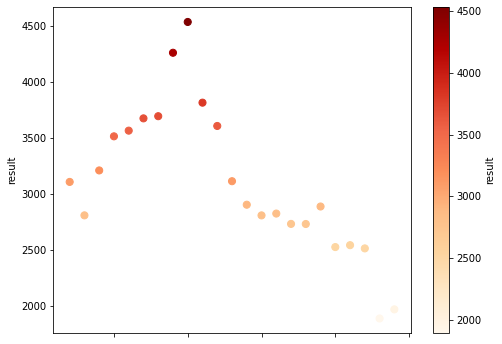

    param1       result
21    28.0  1889.242690
22    29.0  1970.449604
20    27.0  2514.413061
18    25.0  2526.298149
19    26.0  2543.250576
16    23.0  2732.083989
15    22.0  2732.900290
13    20.0  2808.953676
1      8.0  2809.255825
14    21.0  2825.231005
17    24.0  2888.151729
12    19.0  2904.071088
0      7.0  3107.459563
11    18.0  3113.856097
2      9.0  3209.933873
3     10.0  3514.161789
4     11.0  3564.881874
10    17.0  3606.600354
5     12.0  3674.462503
6     13.0  3693.821434
9     16.0  3814.509475
7     14.0  4259.702650
8     15.0  4534.413358


In [ ]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df['2021-01-01':]

# -- Condition to BUY market --
def buyCondition(row):
  if row['TRIX_HISTO'] > 0 and row['STOCH_RSI'] < stochTop:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0 and row['STOCH_RSI'] > stochBottom:
    return True
  else:
    return False

loopI = [7,30,1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

count = 0
maxCount = enumI
for i in range(loopI[0], loopI[1], loopI[2]):
  clear_output(wait=True)
  count += 1
  print("Loading...",count,'/',maxCount)
  # -- You can change variables below --
  usdt = 1000
  coin = 0

  dfTest['STOCH_RSI'] = ta.momentum.stochrsi(close=dfTest['close'], window=i, smooth1=3, smooth2=3)

  for index, row in dfTest.iterrows():
    #BUY
    if buyCondition(row) and usdt > 0:
      coin = (usdt/dfTest['close'][index]) - 0.0007*(usdt/dfTest['close'][index])
      usdt = 0

    #SELL
    elif sellCondition(row) and coin > 0:
      usdt = coin*dfTest['close'][index] - (0.0007*coin*dfTest['close'][index])
      coin = 0

  myrow = {'param1': i,'result': coin*dfTest.iloc[len(dfTest)-1]['close'] + usdt}
  dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y=1,c='result',s=50,colormap='OrRd',figsize=(8,6))
plt.show()

print(dt.sort_values(by=['result']))

<h1>2 Parameters optimizer</h1>


Loading... 40 / 40


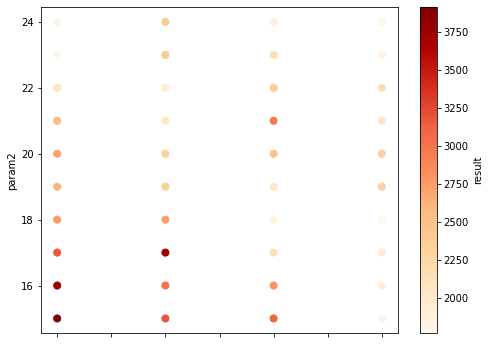

    param1  param2       result
33    10.0    18.0  1766.141735
8      7.0    23.0  1773.066863
39    10.0    24.0  1793.811084
9      7.0    24.0  1801.883974
30    10.0    15.0  1815.220492
38    10.0    23.0  1828.425157
23     9.0    18.0  1857.561057
29     9.0    24.0  1868.105507
31    10.0    16.0  1897.886375
17     8.0    22.0  1937.827883
32    10.0    17.0  1982.381953
24     9.0    19.0  2043.760041
36    10.0    21.0  2054.965801
16     8.0    21.0  2060.148514
7      7.0    22.0  2081.363544
22     9.0    17.0  2134.762498
28     9.0    23.0  2138.423206
37    10.0    22.0  2191.154096
15     8.0    20.0  2302.275071
14     8.0    19.0  2330.130724
35    10.0    20.0  2335.114819
34    10.0    19.0  2336.203665
18     8.0    23.0  2394.709483
27     9.0    22.0  2401.299120
19     8.0    24.0  2431.786303
25     9.0    20.0  2506.999438
6      7.0    21.0  2561.953935
4      7.0    19.0  2624.710421
5      7.0    20.0  2706.912159
13     8.0    18.0  2746.376825
3      7

In [ ]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1','param2', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df['2021-01-01':]


# -- Condition to BUY market --
def buyCondition(row):
  if row['TRIX_HISTO'] > 0 and row['STOCH_RSI'] < stochTop:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0 and row['STOCH_RSI'] > stochBottom:
    return True
  else:
    return False

loopI = [7,11,1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

loopJ = [15,25,1]
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

count = 0
maxCount = enumI * enumJ
for i in range(loopI[0], loopI[1], loopI[2]):
  for j in range(loopJ[0], loopJ[1], loopJ[2]):
    clear_output(wait=True)
    count += 1
    print("Loading...",count,'/',maxCount)
    # -- You can change variables below --
    usdt = 1000
    coin = 0

    trixLength = i
    trixSignal = j
    dfTest['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=dfTest['close'], window=trixLength), window=trixLength), window=trixLength)
    dfTest['TRIX_PCT'] = dfTest["TRIX"].pct_change()*100
    dfTest['TRIX_SIGNAL'] = ta.trend.sma_indicator(dfTest['TRIX_PCT'],trixSignal)
    dfTest['TRIX_HISTO'] = dfTest['TRIX_PCT'] - dfTest['TRIX_SIGNAL']

    for index, row in dfTest.iterrows():
      #BUY
      if buyCondition(row) and usdt > 0:
        coin = (usdt/dfTest['close'][index]) - 0.0007*(usdt/dfTest['close'][index])
        usdt = 0

      #SELL
      elif sellCondition(row) and coin > 0:
        usdt = coin*dfTest['close'][index] - (0.0007*coin*dfTest['close'][index])
        coin = 0

    myrow = {'param1': i, 'param2': j,'result': coin*dfTest.iloc[len(dfTest)-1]['close'] + usdt}
    dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y='param2',c='result',s=50,colormap='OrRd',figsize=(8,6))
plt.show()

print(dt.sort_values(by=['result']))

<h1>3 Parameters optimizer</h1>

Loading... 196 / 196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


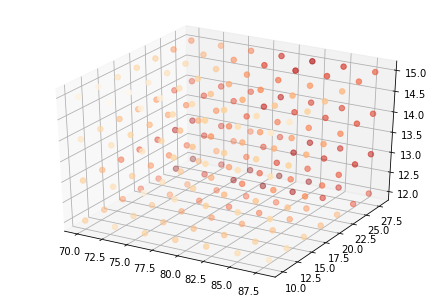

     param1  param2  param3       result
31     73.0    10.0    15.0  2653.132376
35     73.0    13.0    15.0  2691.966904
3      70.0    10.0    15.0  2851.133604
7      70.0    13.0    15.0  2892.866323
59     76.0    10.0    15.0  2971.326409
..      ...     ...     ...          ...
80     76.0    28.0    12.0  7628.159294
104    79.0    25.0    12.0  7638.137458
20     70.0    25.0    12.0  7687.094260
108    79.0    28.0    12.0  7803.977743
24     70.0    28.0    12.0  7853.997502

[196 rows x 4 columns]


In [ ]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1','param2', 'param3', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df['2021-01-01':]


# -- Condition to BUY market --
def buyCondition(row, param):
  if row['TRIX_HISTO'] > 0 and row['STOCH_RSI'] < param:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row, param):
  if row['TRIX_HISTO'] < 0 and row['STOCH_RSI'] > param:
    return True
  else:
    return False

loopI = [70,90,3]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

loopJ = [10,30,3]
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

loopK = [12,16,1]
enumK = ceil((loopK[1] - loopK[0]) / loopK[2])

count = 0
maxCount = enumI * enumJ * enumK
for i in range(loopI[0], loopI[1], loopI[2]):
  for j in range(loopJ[0], loopJ[1], loopJ[2]):
    for k in range(loopK[0], loopK[1], loopK[2]):
      clear_output(wait=True)
      count += 1
      print("Loading...",count,'/',maxCount)
      # -- You can change variables below --
      usdt = 1000
      coin = 0

      trixLength = i
      trixSignal = j
      dfTest['STOCH_RSI'] = ta.momentum.stochrsi(close=dfTest['close'], window=k, smooth1=3, smooth2=3)

      for index, row in dfTest.iterrows():
        #BUY
        if buyCondition(row, i/100) and usdt > 0:
          coin = (usdt/dfTest['close'][index]) - 0.0007*(usdt/dfTest['close'][index])
          usdt = 0

        #SELL
        elif sellCondition(row, j/100) and coin > 0:
          usdt = coin*dfTest['close'][index] - (0.0007*coin*dfTest['close'][index])
          coin = 0

      myrow = {'param1': i, 'param2': j, 'param3': k,'result': coin*dfTest.iloc[len(dfTest)-1]['close'] + usdt}
      dt = dt.append(myrow,ignore_index=True)   

# dt.plot.scatter(x='param1',y='param2',c='result',s=50,colormap='rainbow',figsize=(8,6))
# plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dt['param1'], dt['param2'], dt['param3'],c=dt['result'],cmap='OrRd', s=30)
plt.show()

print(dt.sort_values(by=['result']))

<h1>RUN the Spot Backtest</h1>

In [ ]:
dfTest = None
# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df['2021-01-01':]

# -- Definition of dt, that will be the dataset to do your trades analyses --
dt = None
dt = pd.DataFrame(columns = ['date','position', 'reason', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

# -- You can change variables below --
usdt = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Do not touch these values --
initalWallet = usdt
wallet = usdt
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True

# -- Condition to BUY market --
def buyCondition(row, previousRow):
  if row['TRIX_HISTO'] > 0 and row['STOCH_RSI'] < stochTop:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row, previousRow):
  if row['TRIX_HISTO'] < 0 and row['STOCH_RSI'] > stochBottom:
    return True
  else:
    return False

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
  # -- Buy market order --
  if buyCondition(row, previousRow) and usdt > 0 and buyReady == True:
    # -- You can define here at what price you buy --
    buyPrice = row['close']

    # -- Define the price of you SL and TP or comment it if you don't want a SL or TP --
    # stopLoss = buyPrice - 0.02 * buyPrice
    # takeProfit = buyPrice + 0.04 * buyPrice

    coin = usdt / buyPrice
    fee = takerFee * coin
    coin = coin - fee
    usdt = 0
    wallet = coin * row['close']

    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet

    # -- You can uncomment the line below if you want to see logs --
    # print("Buy COIN at",buyPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index, 'position': "Buy", 'reason':'Buy Market Order','price': buyPrice,'frais': fee,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  # -- Stop Loss --
  elif row['low'] < stopLoss and coin > 0:
    sellPrice = stopLoss
    usdt = coin * sellPrice
    fee = makerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = False
    wallet = usdt

    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet
      
    # -- You can uncomment the line below if you want to see logs --
    # print("Sell COIN at Stop Loss",sellPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index,'position': "Sell", 'reason':'Sell Stop Loss','price': sellPrice,'frais': fee,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)    

  # -- Sell Market Order --
  elif sellCondition(row, previousRow) and coin > 0 and sellReady == True:

    # -- You can define here at what price you buy --
    sellPrice = row['close']
    usdt = coin * sellPrice
    fee = takerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = True
    wallet = usdt

    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet

    # -- You can uncomment the line below if you want to see logs --  
    # print("Sell COIN at",sellPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index,'position': "Sell", 'reason':'Sell Market Order','price': sellPrice,'frais': fee,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  previousRow = row

# -- BackTest Analyses --
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPercentage = ((lastClose - iniClose)/iniClose) * 100
algoPercentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPercentage = ((algoPercentage - holdPercentage)/holdPercentage) * 100

try:
    tradesPerformance = round(dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].sum()
            / dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].count(), 2)
except:
    tradesPerformance = 0
    print("/!\ There is no Good or Bad Trades in your BackTest, maybe a problem...")

try:
    totalGoodTrades = dt.groupby('tradeIs')['date'].nunique()['Good']
    AveragePercentagePositivTrades = round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(), 2)
    idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
    bestTrade = str(
        round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(), 2))
except:
    totalGoodTrades = 0
    AveragePercentagePositivTrades = 0
    idbest = ''
    bestTrade = 0
    print("/!\ There is no Good Trades in your BackTest, maybe a problem...")

try:
    totalBadTrades = dt.groupby('tradeIs')['date'].nunique()['Bad']
    AveragePercentageNegativTrades = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(), 2)
    idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
    worstTrade = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(), 2)
except:
    totalBadTrades = 0
    AveragePercentageNegativTrades = 0
    idworst = ''
    worstTrade = 0
    print("/!\ There is no Bad Trades in your BackTest, maybe a problem...")

totalTrades = totalBadTrades + totalGoodTrades
winRateRatio = (totalGoodTrades/totalTrades) * 100

reasons = dt['reason'].unique()

dt

,date,position,reason,price,frais,fiat,coins,wallet,drawBack,resultat,resultat%,tradeIs
date,,,,,,,,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,Buy,Buy Market Order,734.07,0.000954,0,1.361314,999.300000,0.000000,NaN,NaN,
2021-01-01 10:00:00,2021-01-01 10:00:00,Sell,Sell Market Order,736.81,0.702121,1002.33,0.000000,1002.327880,0.000000,3.027880,0.303000,Good
2021-01-02 09:00:00,2021-01-02 09:00:00,Buy,Buy Market Order,725.41,0.000967,0,1.380773,1001.626251,-0.000700,NaN,NaN,
2021-01-03 00:00:00,2021-01-03 00:00:00,Sell,Sell Market Order,775.81,0.749852,1070.47,0.000000,1070.467338,0.000000,68.841087,6.872932,Good
2021-01-03 18:00:00,2021-01-03 18:00:00,Buy,Buy Market Order,917.54,0.000817,0,1.165854,1069.718011,-0.000700,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30 08:00:00,2021-09-30 08:00:00,Buy,Buy Market Order,2976.56,0.001779,0,2.539832,7559.963290,-0.047335,NaN,NaN,
2021-09-30 12:00:00,2021-09-30 12:00:00,Sell,Sell Market Order,3008.36,5.348511,7635.38,0.000000,7635.381447,-0.037831,75.418157,0.997600,Good
2021-10-01 13:00:00,2021-10-01 13:00:00,Buy,Buy Market Order,3200.30,0.001670,0,2.384163,7630.036680,-0.038505,NaN,NaN,


<h1>Print Complete BackTest Analyses</h1>

In [ ]:
print("Pair Symbol :",pairName)
print("Period : [" + str(dfTest.index[0]) + "] -> [" +
      str(dfTest.index[len(dfTest)-1]) + "]")
print("Starting balance :", initalWallet, "$")

print("\n----- General Informations -----")
print("Final balance :", round(wallet, 2), "$")
print("Performance vs US Dollar :", round(algoPercentage, 2), "%")
print("Buy and Hold Performence :", round(holdPercentage, 2), "%")
print("Performance vs Buy and Hold :", round(vsHoldPercentage, 2), "%")
print("Best trade : +"+bestTrade, "%, the", idbest)
print("Worst trade :", worstTrade, "%, the", idworst)
print("Worst drawBack :", str(100*round(dt['drawBack'].min(), 2)), "%")
print("Total fees : ", round(dt['frais'].sum(), 2), "$")

print("\n----- Trades Informations -----")
print("Total trades on period :",totalTrades)
print("Number of positive trades :", totalGoodTrades)
print("Number of negative trades : ", totalBadTrades)
print("Trades win rate ratio :", round(winRateRatio, 2), '%')
print("Average trades performance :",tradesPerformance,"%")
print("Average positive trades :", AveragePercentagePositivTrades, "%")
print("Average negative trades :", AveragePercentageNegativTrades, "%")

print("\n----- Trades Reasons -----")
reasons = dt['reason'].unique()
for r in reasons:
    print(r+" number :", dt.groupby('reason')['date'].nunique()[r])

Pair Symbol : ETHUSDT
Period : [2021-01-01 00:00:00] -> [2021-10-02 21:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 7855.73 $
Performance vs US Dollar : 685.57 %
Buy and Hold Performence : 367.74 %
Performance vs Buy and Hold : 86.43 %
Best trade : +21.44 %, the 2021-05-25 00:00:00
Worst trade : -12.51 %, the 2021-02-23 09:00:00
Worst drawBack : -24.0 %
Total fees :  616.22 $

----- Trades Informations -----
Total trades on period : 229
Number of positive trades : 120
Number of negative trades :  109
Trades win rate ratio : 52.4 %
Average trades performance : 1.07 %
Average positive trades : 3.93 %
Average negative trades : -2.07 %

----- Trades Reasons -----
Buy Market Order number : 230
Sell Market Order number : 229


<h1>Plot to improve ...</h1>


----- Plot -----


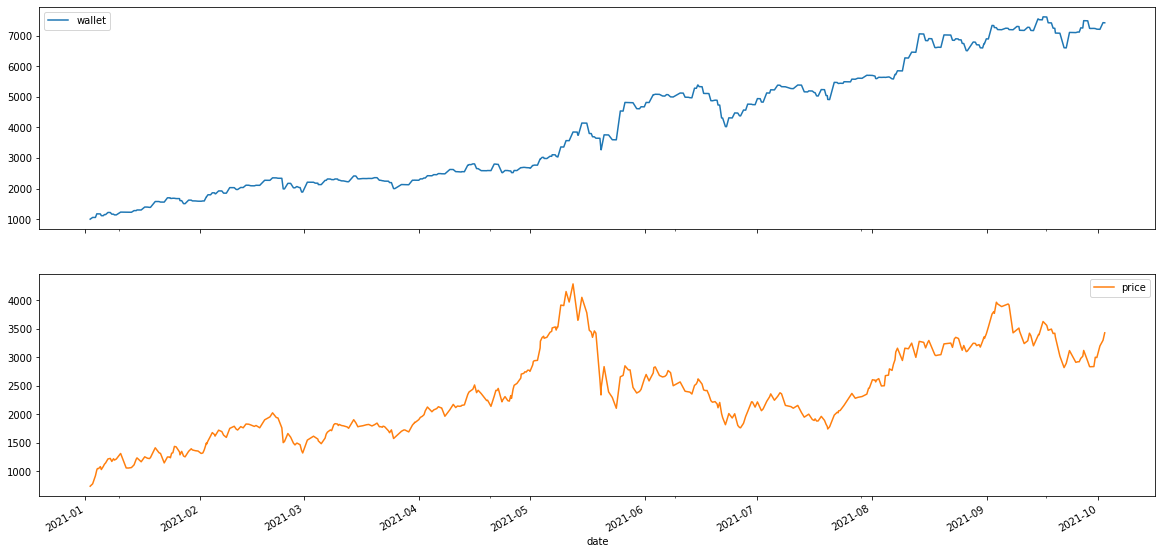

In [ ]:
dt[['wallet', 'price']].plot(subplots=True, figsize=(20, 10))
print("\n----- Plot -----")